# Purpose
The purpose of this notebook is to check some of the math that is used throughout to ensure (visually) that it is doing what I think it is doing.  We won't be checking the basic math operations, or other things that are easily checked in the unit tests.

First, we'll do our normal imports, and add the first two lines that form our initial test application.  From there, we'll walk through step-by-step the major parts of the math the application depends on:

1. Calculation of the normal vectors
2. Determining _which_ normal vectors to match with
3. Ray-casting
4. Hit determination

#### Calculation of the normal vectors

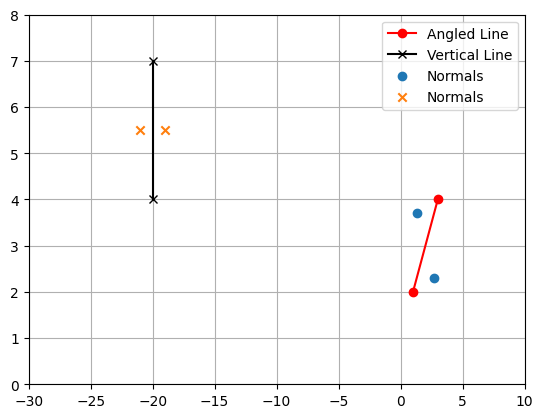

In [32]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np


class Point2D(object):
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Point2D(self.x + other.x, self.y + other.y)


class Line2D(object):
    def __normalize_point(p: Point2D) -> Point2D:
        # TODO: Should do this in the simulation code.
        mag = sqrt((p.x * p.x) + (p.y * p.y))
        return Point2D(p.x / mag, p.y / mag)

    def __init__(self, p1: Point2D, p2: Point2D):
        self.p1 = p1
        self.p2 = p2
        self.midpoint: Point2D = Point2D((p1.x + p2.x) / 2.0, (p1.y + p2.y) / 2.0)

        dy = p2.y - p1.y
        dx = p2.x - p1.x
        self.normals: list[Point2D] = [Point2D(-dy, dx), Point2D(dy, -dx)]
        self.normals = [Line2D.__normalize_point(x) for x in self.normals]

        self.ref_translated_normals: list[Point2D] = [
            self.normals[0] + self.midpoint,
            self.normals[1] + self.midpoint,
        ]


def plot_line(line: Line2D, marker: str, color: str):
    plt.plot([line.p1.x, line.p2.x], [line.p1.y, line.p2.y], marker=marker, color=color)


line1 = Line2D(Point2D(1.0, 2.0), Point2D(3.0, 4.0))
line2 = Line2D(Point2D(-20.0, 4.0), Point2D(-20.0, 7.0))

ax = plt.gca()
plt.grid(True)
ax.set_xlim([-30, 10])
ax.set_ylim([0, 8])

plot_line(line1, marker="o", color="red")
plot_line(line2, marker="x", color="black")

plt.scatter(
    [x.x for x in line1.ref_translated_normals],
    [y.y for y in line1.ref_translated_normals],
    marker="o",
)

plt.scatter(
    [x.x for x in line2.ref_translated_normals],
    [y.y for y in line2.ref_translated_normals],
    marker="x",
)

plt.legend(["Angled Line", "Vertical Line", "Normals", "Normals"])

plt.show()

##### Notes on the initial plot
Depending on how you set up the plot--the normals (particularly for the angled line) appear to be skewed.  However, if you adjust the plot enough you can show that they are in the correct location.

If we form a vector from from $P_1$ to $P_2$ via ($P_2 - P_1$), we can find a generalized 2d rotation of 90 degrees (since the normal should be perpindicular to the line) via:
$$
x' = x\cos{\theta} - y\sin{\theta}
$$
$$
y' = x\sin{\theta} + y\cos{\theta}
$$

Then, realizing that $\cos{90}$ is $0$ and $\sin{90}$ is $1$,

$$
x' = -y
$$
$$
y' = x
$$

This gives us our first normal of $(-dy, dx)$.  However, every line potentially has two normals--one at 90 degrees, and one at 270 degrees.  Plugging in $\theta=270$ in the aforementioned equations, and remembering that $\cos{270}$ is $0$ and $\sin{270}$ is $-1$:

$$
x' = y
$$
$$
y' = -x
$$

This gives us the second normal of $(dy, -dx)$

One final note, on the plot I do shift the normals to the midpoint of the line.

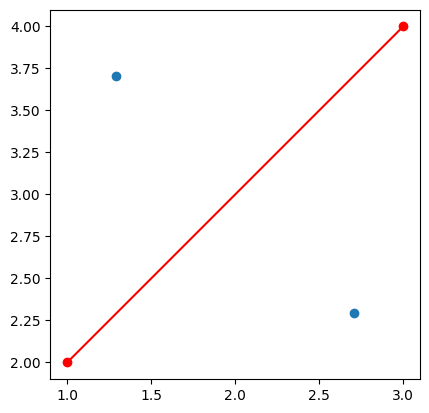

In [33]:
# Just a quick plot of the normals on the angled line to prove that they're where you think
plt.plot()
plot_line(line1, marker="o", color="red")
plt.scatter(
    [x.x for x in line1.ref_translated_normals],
    [y.y for y in line1.ref_translated_normals],
    marker="o",
)
plt.gca().set_aspect("equal")
plt.show()

#### Determining _which_ normal vectors to match with
In simulation, we go through each shape (and its normals)--and compare them with the normals of every other shape that is present in the simulation.  The difficulty is that since we allow users to place shapes anywhere two things are true:
1. _Either_ normal could be the "correct" one
2. Even checking if normals are "facing" each-other with the dot product is not always enough

